In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# !pip install xgboost
import xgboost
from xgboost import XGBClassifier
# !pip install lightgbm
import lightgbm as lgb
# !pip install catboost
from catboost import CatBoostClassifier, Pool

In [2]:
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### XGBoost

In [3]:
xgb = XGBClassifier(learning_rate=0.01,
              eval_metric='auc',
              early_stopping_rounds=10,
              importance_type='total_gain',
              random_state=0)
# 学習
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type='total_gain', interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [4]:
# 予測と評価
y_pred_xgb = xgb.predict_proba(X_test)
print(f"xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

xgboost AUC: 0.8990384615384616


In [5]:
# 特徴量の重要度
xgb.feature_importances_

array([0.        , 0.        , 0.10952041, 0.        , 0.        ,
       0.22573482, 0.        , 0.        , 0.        , 0.59854376,
       0.05928717, 0.        , 0.00691384], dtype=float32)

<AxesSubplot:>

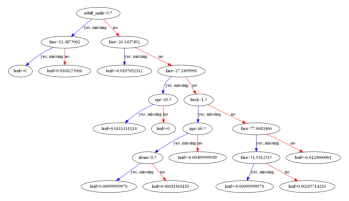

In [6]:
# 弱学習器の木構造を描画
xgboost.plot_tree(xgb, num_trees=0)